## About Data


## Code


### Import libraries


In [11]:
import os
import random
import librosa
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt
import scipy.signal as signal
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

In [12]:
#@title Assign Numbers to Classes
classes = {
    'normal': 0, # Normal Heartbeat Sound
    'murmur': 1, # Murmur Heartbeat Sound
    'extrahs': 2, # Extra Heart Sound
    #'extrastole': 3, # Extrasystole Heartbeat Sound
    'artifact': 3 # Artifact sound
}

In [13]:
#@title Folder Paths Dataset A
folder_paths_a = {
    'normal': './data/train/dataset_a/Atraining_normal',
    'murmur': './data/train/dataset_a/Atraining_murmur',
    'extrahs': './data/train/dataset_a/Atraining_extrahs',
    'artifact': './data/train/dataset_a/Atraining_artifact'
}

In [14]:
#@title Folder Paths Dataset B
folder_paths_b = {
    'normal': './data/train/dataset_b/Btraining_normal',
    'murmur': './data/train/dataset_b/Btraining_murmur',
    'extrastole': './data/train/dataset_b/Btraining_extrastole'
}

### Functions


In [15]:
def load_data(folder_path, cl):
    x = []
    y = []
    samples_rate = []

    file_names = os.listdir(folder_path)
    
    for file_name in file_names:
        try:
            file_path = os.path.join(folder_path, file_name)
        except:
            print(f"Error loading data of '{folder_path}'")
        else:
            audio, sr = librosa.load(file_path, sr=None)
            x.append(audio)
            label = classes.get(cl)
            y.append(label)
            samples_rate.append(sr)
            
    return x, y, samples_rate

In [16]:
def get_spectrum(audio, sample_rate):
    frequencies = np.fft.fftfreq(len(audio), d=1/sample_rate)
    fft_values = np.fft.fft(audio)

    # Absolute values
    magnitudes = np.abs(fft_values)

    half_freq = frequencies[:len(frequencies)//2]
    half_magn = magnitudes[:len(magnitudes)//2]

    # Find dominant frequency index
    dominant_index = np.argmax(half_magn)

    # Get dominant frequency
    dominant_frequency = frequencies[dominant_index]
    
    return half_freq, half_magn, dominant_frequency

In [17]:
# This function adjusts the duration of the audio segments to the desired time as well as setting a new sample rate for each one so that they all have the same one.
def fix_audio_length(audio_data, orig_sr, time_duration, target_sr=44100):
    data_fix = []
    new_length = int(target_sr*time_duration)
    cont = 0
    # change the sample rate to the desired one
    for audio, sr in zip(audio_data, orig_sr):
        if target_sr != sr:
            resample_audio = librosa.resample(y=audio, orig_sr=sr, target_sr=target_sr)
            data_fix.append(resample_audio)
        else:
            data_fix.append(audio)
            
    # fix audio length
    for idx, audio in enumerate(data_fix):
        dur = librosa.get_duration(y=audio, sr=target_sr) # duraation

        if dur != time_duration:
            fixed_element = audio
            
            if dur < time_duration:
                fixed_element = np.tile(audio, int(np.ceil(new_length/len(audio)))) # Repeat the audio until completing the time or more
                
            fixed_element = fixed_element[:new_length] # Take the number of samples that complete the desired time
            data_fix[idx] = fixed_element
            
    return data_fix

In [18]:
def IIR_filter(audio, sample_rate, cutoff_freq, N):
    # Design IIR filter
    nyquist_freq = 0.5 * sample_rate
    normalized_cutoff = cutoff_freq / nyquist_freq
    b, a = signal.butter(N=N, Wn=normalized_cutoff, btype='low', analog=False)

    # Aplicar el filtro de paso bajo a la señal de audio
    filtered_audio = signal.lfilter(b, a, audio)
    
    return filtered_audio


In [19]:
def get_cardiac_frequency(frequencies, magnitudes, cutoff_inf, cutoff_sup):
    # Obtener el índice correspondiente a la frecuencia de corte inferior (0 Hz)
    inf = np.where(frequencies >= cutoff_inf)[0][0]

    # Obtener el índice correspondiente a la frecuencia de corte superior (10 Hz)
    sup = np.where(frequencies <= cutoff_sup)[0][-1]

    # Extraer el rango de frecuencias
    freq_range = frequencies[inf : sup + 1]
    magn_range = magnitudes[inf : sup + 1]
    
    idx_max_ampl = np.argmax(magn_range)
    
    freq = freq_range[idx_max_ampl]
    # Imprimir el resultado
    return freq

In [20]:
def data_aum(audio_data, labels, sample_rates, target_num, min_freq, max_freq):
    random.seed(42)
    
    new_data = []
    new_sample_rates = []
    new_labels = []
    
    new_data += audio_data
    new_sample_rates += sample_rates
    new_labels += labels
    
    while len(new_data) != target_num:
        idx = random.randint(0, len(audio_data)-1)
        
        audio = audio_data[idx]
        sr = sample_rates[idx]
        
        frequencies, magnitudes, _ = get_spectrum(audio, sr)
        
        cardiac_freq = get_cardiac_frequency(frequencies, magnitudes, cutoff_inf=0, cutoff_sup=5)
        
        if cardiac_freq/min_freq >= 1 and cardiac_freq/max_freq <= 1:
            dif_inf = min_freq/cardiac_freq
            dif_sup = max_freq/cardiac_freq 
            
            rate = random.randint(int(dif_inf * 10), int(dif_sup * 10))
            rate/=10
            
            modified_audio = librosa.effects.time_stretch(audio, rate=rate)
            
            orig_duration = len(audio) / sr
            res_duration = len(modified_audio) / sr

            # New sample_rate
            new_sr = sr * (orig_duration / res_duration)    
            
            new_data.append(modified_audio)
            new_sample_rates.append(new_sr)
            new_labels.append(labels[idx])
            
    return new_data, new_labels, new_sample_rates

In [21]:
def get_spectrogram(audio, sample_rate):
    # Calculate the spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)

    # Convert to logarithmic scale
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    
        
    return log_spectrogram

### Load Data


In [22]:
#@title Load set A
# Dataset A
normal_a_data, normal_a_labels, normal_a_sr = load_data(folder_paths_a.get('normal'), 'normal')
murmur_a_data, murmur_a_labels, murmur_a_sr = load_data(folder_paths_a.get('murmur'), 'murmur')
extrahs_data, extrahs_labels, extrahs_sr = load_data(folder_paths_a.get('extrahs'), 'extrahs')
artifact_data, artifact_labels, artifact_sr = load_data(folder_paths_a.get('artifact'), 'artifact')
# Dataset B
#normal_b_data, normal_b_labels, normal_b_sr = load_data(folder_paths_b.get('normal'), classes.get('normal'))
#murmur_b_data, murmur_b_labels, murmur_b_sr = load_data(folder_paths_b.get('murmur'), classes.get('murmur'))
#extrastole_data, extrastole_labels, extrastole_sr = load_data(folder_paths_b.get('extrastole'), classes.get('extrastole'))

# Num data per class set A
num_normal_a = len(normal_a_data)
num_murmur_a = len(murmur_a_data)
num_extrahs = len(extrahs_data)
num_artifact = len(artifact_data)
# Num data per class set B
#num_normal_b = len(normal_b_data)
#num_murmur_b = len(murmur_b_data)
#num_extrastole = len(extrastole_data)

print('DATASET A')
print(f'Normal class: {num_normal_a} - Average sample rates: {np.mean(normal_a_sr)}')
print(f'Murmur class: {num_murmur_a} - Average sample rates: {np.mean(murmur_a_sr)}')
print(f'Extrahs class: {num_extrahs} - Average sample rates: {np.mean(extrahs_sr)}')
print(f'Artifact class: {num_artifact} - Average sample rates: {np.mean(artifact_sr)}')
#print('\n')
#print('DATASET B')
#print(f'Normal class: {num_normal_b} - Average sample rates: {np.mean(normal_b_sr)}')
#print(f'Murmur class: {num_murmur_b} - Average sample rates: {np.mean(murmur_b_sr)}')
#print(f'Extrastole class: {num_extrastole} - Average sample rates: {np.mean(extrastole_sr)}')

DATASET A
Normal class: 31 - Average sample rates: 44100.0
Murmur class: 34 - Average sample rates: 44100.0
Extrahs class: 19 - Average sample rates: 44100.0
Artifact class: 40 - Average sample rates: 44100.0


### Data Visualization


Text(0, 0.5, 'Num Data')

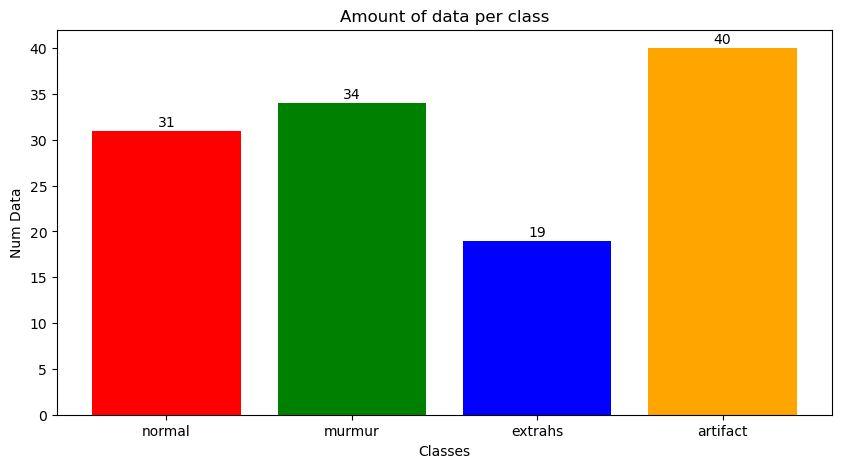

In [23]:
#@title Data distribution of each dataset
fig, axs = plt.subplots(1, 1, figsize=(10,5))
#fig.suptitle('Amount of data per class')
# Bar Graph Dataset A
plt.bar(['normal', 'murmur', 'extrahs', 'artifact'], [num_normal_a, num_murmur_a, num_extrahs, num_artifact], color=['red', 'green', 'blue', 'orange']
)
for i, v in enumerate([num_normal_a, num_murmur_a, num_extrahs, num_artifact]):
    plt.text(i, v + 0.5, str(v), color='black', ha='center')
# Set title subplot A
plt.title('Amount of data per class')
# Set labels subplot A
plt.xlabel('Classes')
plt.ylabel('Num Data')
#plt.set(xlabel='Classes', ylabel='Num Data')
# Bar Graph Dataset B
#axs[1].bar(['normal', 'murmur', 'extrastole'], [num_normal_b, num_murmur_b, num_extrastole], color=['red', 'green', 'purple']
#)
#for i, v in enumerate([num_normal_b, num_murmur_b, num_extrastole]):
#    axs[1].text(i, v + 0.5, str(v), color='black', ha='center')

#axs[1].set_title('Set B')
#axs[1].set(xlabel='Classes', ylabel='Num Data')
#plt.show()

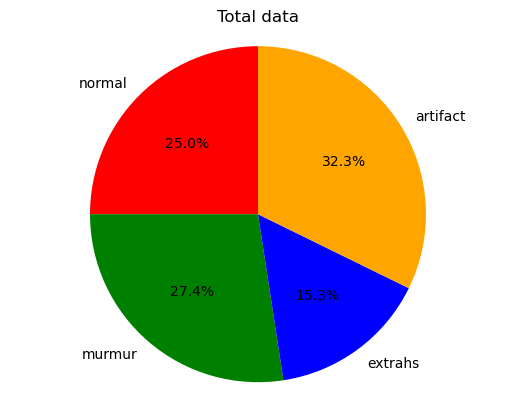

In [24]:
#@title Total Data
#num_normal = num_normal_a + num_normal_b
#num_murmur = num_murmur_a + num_murmur_b

#num_classes = [num_normal, num_murmur, num_extrahs, num_extrastole, num_artifact]
#tags = ['normal', 'murmur', 'extrahs', 'extrastole', 'artifact']

num_classes = [num_normal_a, num_murmur_a, num_extrahs, num_artifact]
tags = ['normal', 'murmur', 'extrahs', 'artifact']

# Pie diagram
#plt.pie(num_classes, labels=tags, autopct='%1.1f%%', startangle=90, colors=['red', 'green', 'blue', 'purple', 'orange'])
plt.pie(num_classes, labels=tags, autopct='%1.1f%%', startangle=90, colors=['red', 'green', 'blue', 'orange'])
plt.axis('equal')
plt.title('Total data')
plt.show()

### Dataset A


##### Normal Sound (normal)


In [25]:
#@title Normal Heartbeat Sound
idx = random.randint(0, len(normal_a_data)-1)
rnd_normal_a = normal_a_data[idx]
rnd_normal_a_sr = normal_a_sr[idx]
# play audio
Audio(rnd_normal_a, rate=rnd_normal_a_sr)

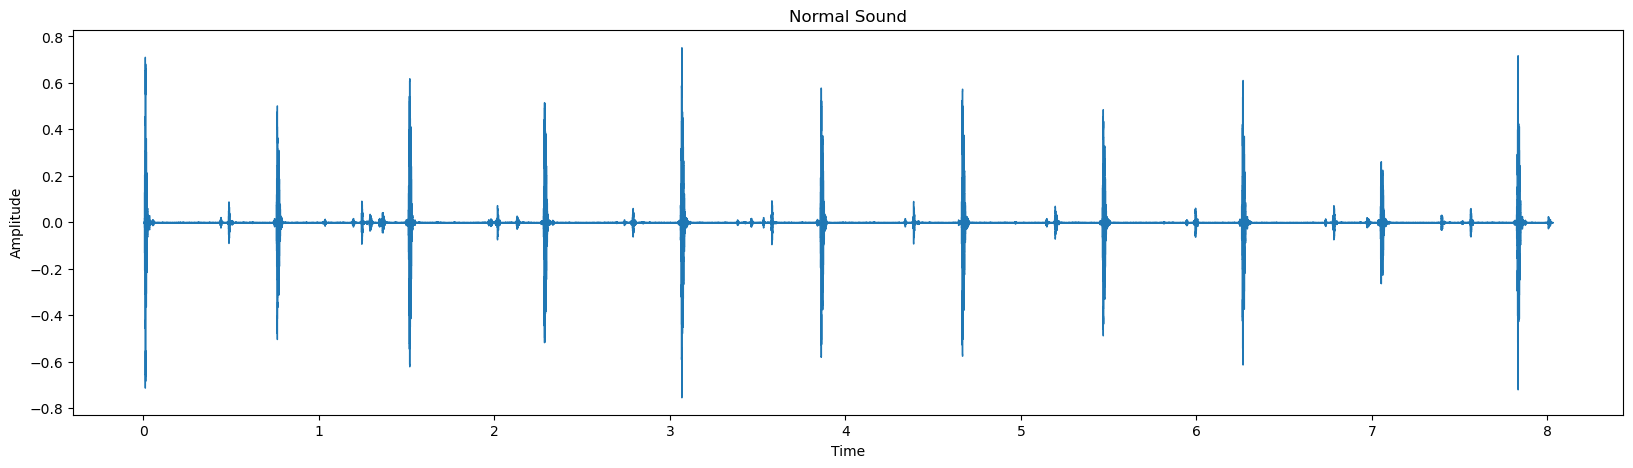

In [26]:
#@title Normal Waveform
plt.figure(figsize=(20,5))
librosa.display.waveshow(rnd_normal_a, sr=rnd_normal_a_sr)
plt.title("Normal Sound")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

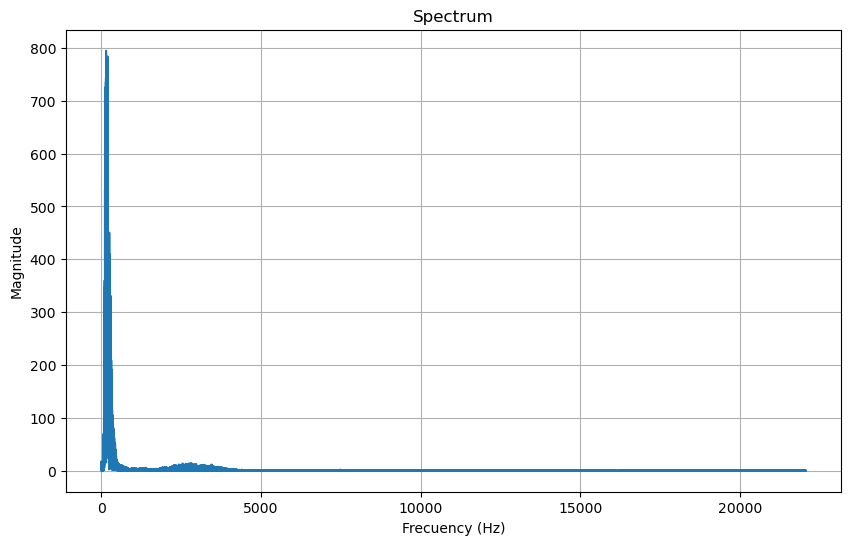

Dominant Frecuency: 154.5332358231376 Hz


In [27]:
#@title Normal Sound Spectrum
frequencies, magnitudes, dominant_frequency = get_spectrum(rnd_normal_a, rnd_normal_a_sr)

# Plot frecuency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, magnitudes)
plt.xlabel('Frecuency (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectrum')
plt.grid(True)
plt.show()

print('Dominant Frecuency:', dominant_frequency, 'Hz')

##### Murmur Sound (murmur)


In [28]:
#@title Murmur Heartbeat Sound
idx = random.randint(0, len(murmur_a_data)-1)
rnd_murmur_a = murmur_a_data[idx]
rnd_murmur_a_sr = murmur_a_sr[idx]
# play audio
Audio(rnd_murmur_a, rate=rnd_murmur_a_sr)

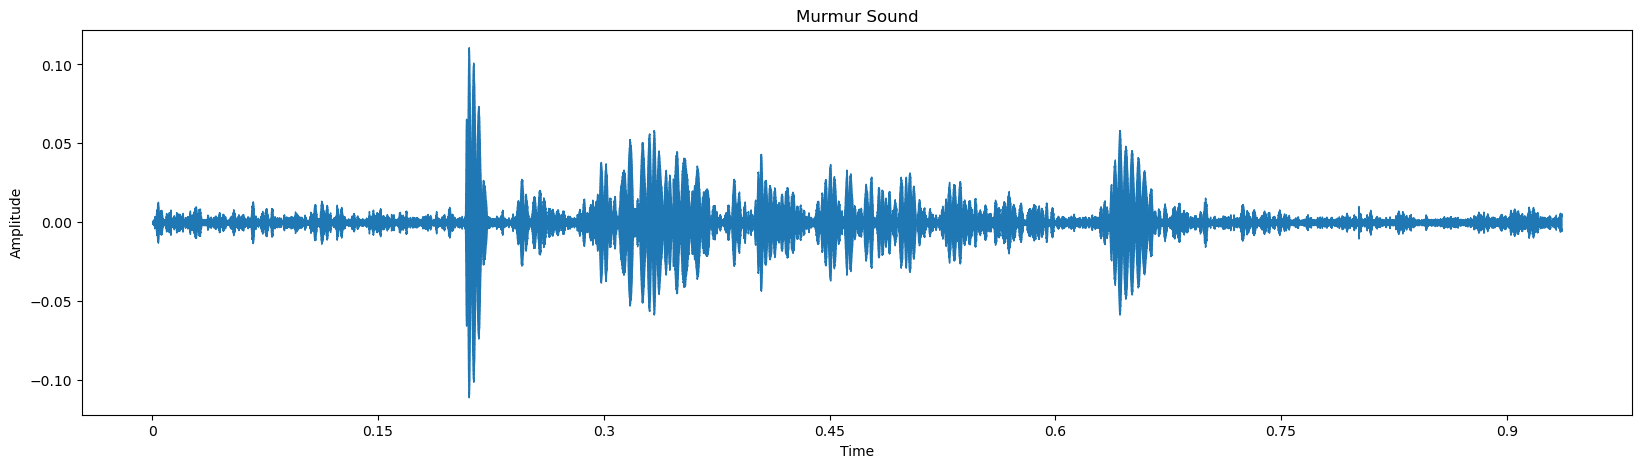

In [29]:
#@title Murmur Waveform
plt.figure(figsize=(20,5))
librosa.display.waveshow(rnd_murmur_a, sr=rnd_murmur_a_sr)
plt.title("Murmur Sound")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

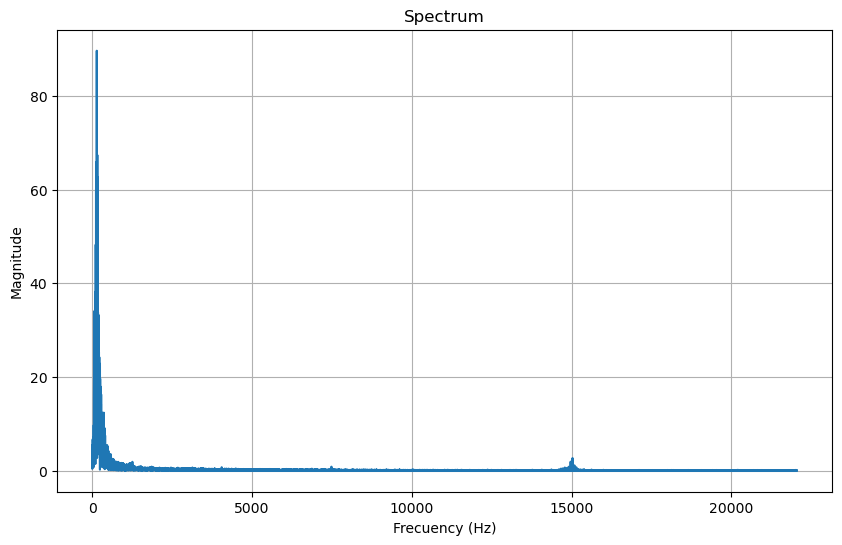

Dominant Frecuency: 140.96963239211507 Hz


In [30]:
#@title Murmur Sound Spectrum
frequencies, magnitudes, dominant_frequency = get_spectrum(rnd_murmur_a, rnd_murmur_a_sr)

# Plot frecuency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, magnitudes)
plt.xlabel('Frecuency (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectrum')
plt.grid(True)
plt.show()

print('Dominant Frecuency:', dominant_frequency, 'Hz')

##### Extra Heart Sound (extrahs)


In [31]:
#@title Extra Heart Sound
idx = random.randint(0, len(extrahs_data)-1)
rnd_extrahs = extrahs_data[idx]
rnd_extrahs_sr = extrahs_sr[idx]
# play audio
Audio(rnd_extrahs, rate=rnd_extrahs_sr)

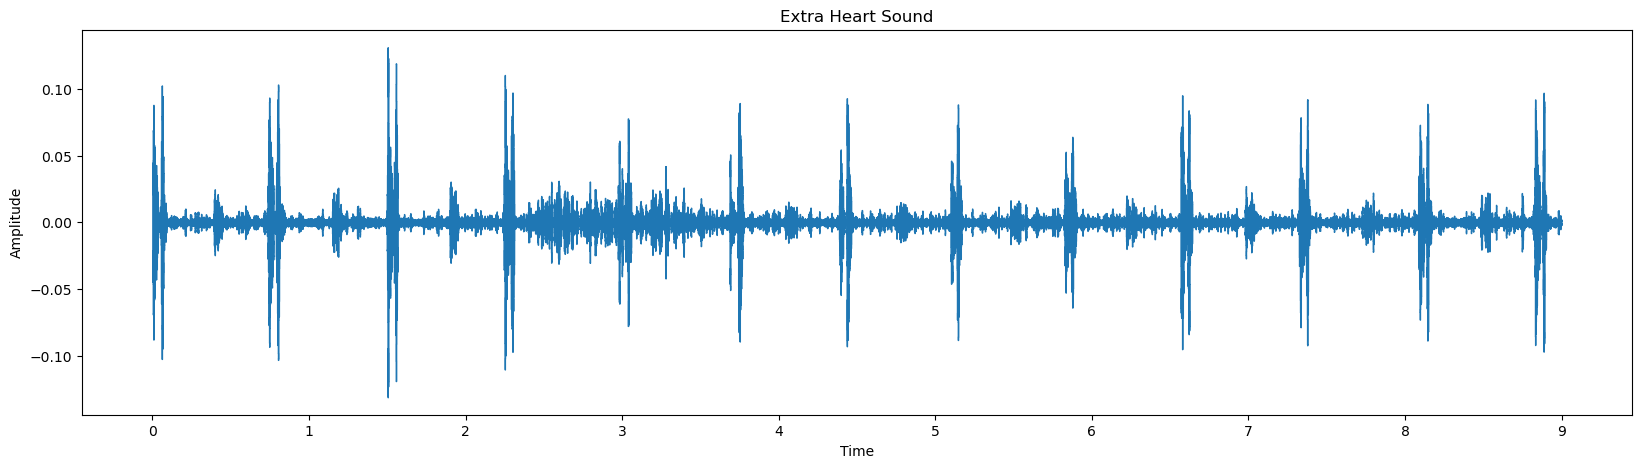

In [32]:
#@title Extra Heart Sound Waveform
plt.figure(figsize=(20,5))
librosa.display.waveshow(rnd_extrahs, sr=rnd_extrahs_sr)
plt.title("Extra Heart Sound")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

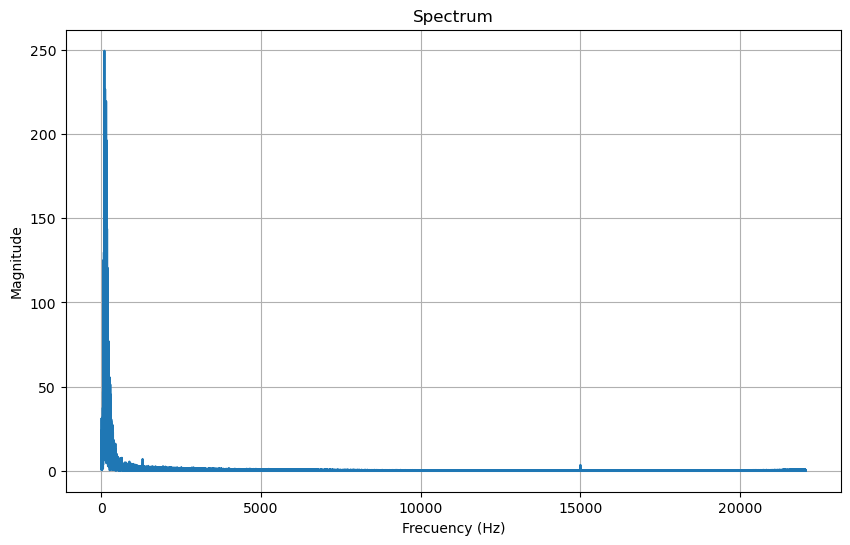

Dominant Frecuency: 102.77777777777777 Hz


In [33]:
#@title Extra Heart Sound Spectrum
frequencies, magnitudes, dominant_frequency = get_spectrum(rnd_extrahs, rnd_extrahs_sr)

# Plot frecuency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, magnitudes)
plt.xlabel('Frecuency (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectrum')
plt.grid(True)
plt.show()

print('Dominant Frecuency:', dominant_frequency, 'Hz')

##### Artifact Sound (artifact)


In [34]:
#@title Artifact sound
idx = random.randint(0, len(artifact_data)-1)
rnd_artifact = artifact_data[idx]
rnd_artifact_sr = artifact_sr[idx]
# play audio
Audio(rnd_artifact, rate=rnd_artifact_sr)

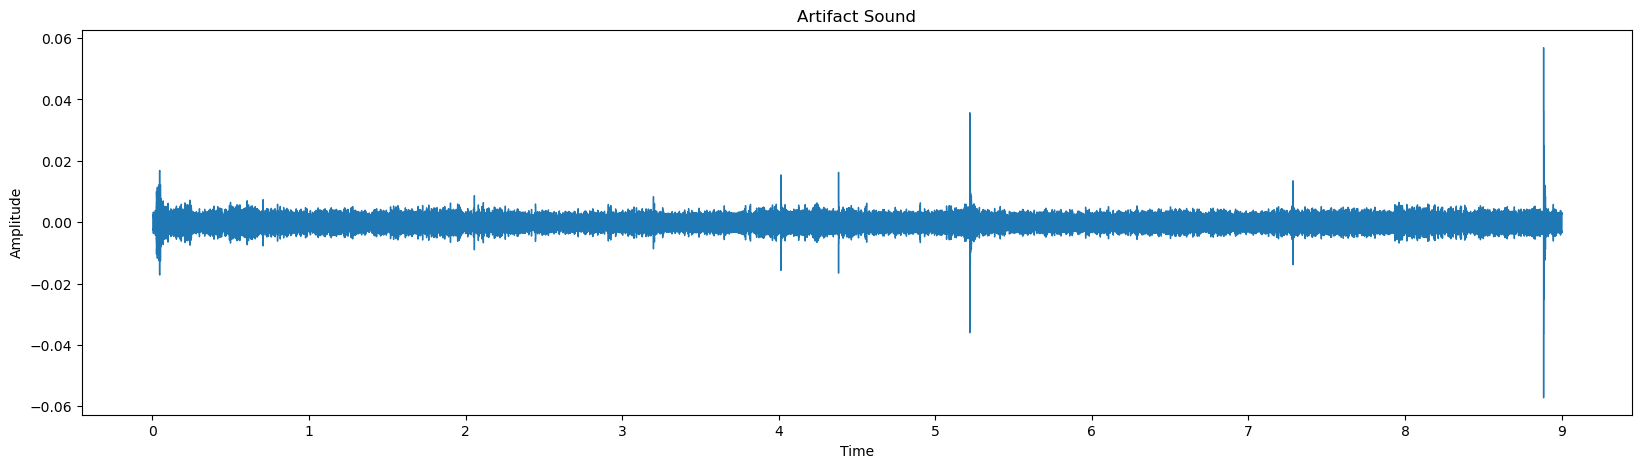

In [35]:
#@title Artifact Waveform
plt.figure(figsize=(20,5))
librosa.display.waveshow(rnd_artifact, sr=rnd_artifact_sr)
plt.title("Artifact Sound")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

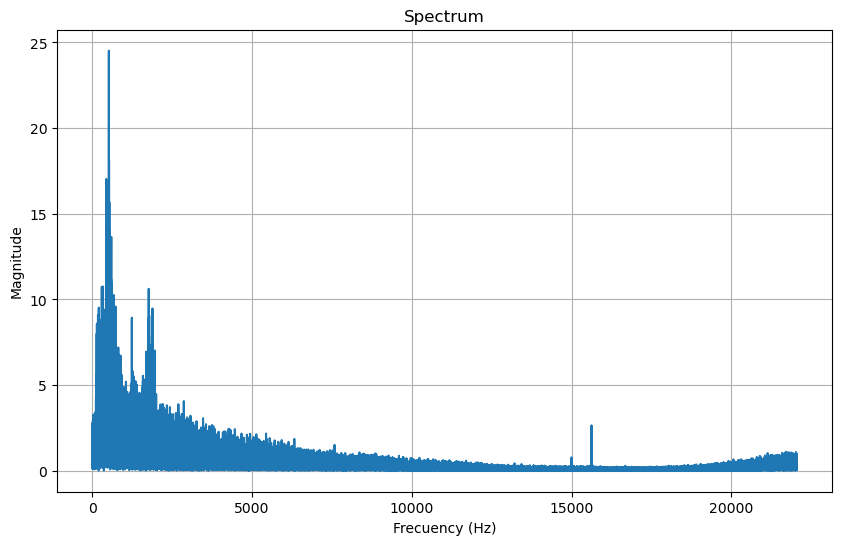

Dominant Frecuency: 519.7777777777777 Hz


In [36]:
#@title Artifact Sound Spectrum
frequencies, magnitudes, dominant_frequency = get_spectrum(rnd_artifact, rnd_artifact_sr)

# Plot frecuency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, magnitudes)
plt.xlabel('Frecuency (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectrum')
plt.grid(True)
plt.show()

print('Dominant Frecuency:', dominant_frequency, 'Hz')

#### Dataset B


##### Normal Sound (normal)


In [37]:
#@title Normal Heartbeat
idx = random.randint(0, len(normal_b_data)-1)
rnd_normal_b = normal_b_data[idx]
rnd_normal_b_sr = normal_b_sr[idx]
# play audio
Audio(rnd_normal_b, rate=rnd_normal_b_sr)

NameError: name 'normal_b_data' is not defined

In [ ]:
#@title Normal Waveform
plt.figure(figsize=(20,5))
librosa.display.waveshow(rnd_normal_b, sr=rnd_normal_b_sr)
plt.title("Normal Sound")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
#@title Normal Sound Spectrum
frequencies, magnitudes, dominant_frequency = get_spectrum(rnd_normal_b, rnd_normal_b_sr)

# Plot frecuency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, magnitudes)
plt.xlabel('Frecuency (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectrum')
plt.grid(True)
plt.show()

print('Dominant Frecuency:', dominant_frequency, 'Hz')

##### Murmur Sound (murmur)


In [ ]:
#@title Murmur Heartbeat Sound
idx = random.randint(0, len(murmur_b_data)-1)
rnd_murmur_b = murmur_b_data[idx]
rnd_murmur_b_sr = murmur_b_sr[idx]
# play audio
Audio(rnd_murmur_b, rate=rnd_murmur_b_sr)

In [ ]:
#@title Murmur Waveform
plt.figure(figsize=(20,5))
librosa.display.waveshow(rnd_murmur_b, sr=rnd_murmur_b_sr)
plt.title("Murmur Sound")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
#@title Murmur Sound Spectrum
frequencies, magnitudes, dominant_frequency = get_spectrum(rnd_murmur_b, rnd_murmur_b_sr)

# Plot frecuency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, magnitudes)
plt.xlabel('Frecuency (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectrum')
plt.grid(True)
plt.show()

print('Dominant Frecuency:', dominant_frequency, 'Hz')

##### Extrasystole Sound (extrastole)


In [ ]:
#@title Extrasistole Heartbeat Sound
idx = random.randint(0, len(extrastole_data)-1)
rnd_extrastole = extrastole_data[idx]
rnd_extrastole_sr = extrastole_sr[idx]
# play audio
Audio(rnd_extrastole, rate=rnd_extrastole_sr)

In [ ]:
#@title Extrasystole Waveform
plt.figure(figsize=(20,5))
librosa.display.waveshow(rnd_extrastole, sr=rnd_extrastole_sr)
plt.title("Extrasystole")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
#@title Extrasystole Sound Spectrum
frequencies, magnitudes, dominant_frequency = get_spectrum(rnd_extrastole, rnd_extrastole_sr)

# Plot frecuency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, magnitudes)
plt.xlabel('Frecuency (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectrum')
plt.grid(True)
plt.show()

print('Dominant Frecuency:', dominant_frequency, 'Hz')

### Data Preprossecing


As it is evident, not all audio files have the same duration, which would pose the first problem. Another important point to highlight is the class imbalance, where a higher number of data points can be noticed for the "murmur" and "normal" classes when considering all the data together.


#### Time Duration & Sample Rate


To solve the first problem, it is necessary to establish an equal time magnitude for all audio segments, which presents three cases:

- The duration is equal. No action would be taken on the audio segment.
- The duration is greater. The audio segment would need to be trimmed.
- The duration is shorter. It is necessary to fill in the missing time.

For the last two cases, the 'librosa.util.fix_length()' function can be used, as it is used to adjust the length of an audio signal based on the number of samples, rather than time. If the signal is shorter than the desired length, the function will fill the signal with repeated copies of the last value until it reaches the specified length. On the other hand, if the signal is longer than the desired length, the function will trim the signal to have the specified length.


### Correct Noise

---

Taking the proposal of the authors of the dataset, a 195 Hz low-pass filter was used, more specifically an IIR filter that helps us attenuate the frequencies present in the signal that are higher than the cutoff frequency and maintain the lower frequencies, which are of our interest.


In [38]:
#@title Process Each Class
cutoff_freq = 195 #Hz
N = 4 # Degree of complexity of the filter
filtered_normal_a = []
filtered_murmur_a = []
filtered_extrahs = []
#filtered_normal_b = []
#filtered_murmur_b = []
#filtered_extrastole = []

for idx, audio in enumerate(normal_a_data):
    filtered_normal_a.append(IIR_filter(audio=audio, sample_rate=normal_a_sr[idx], cutoff_freq=cutoff_freq, N=N))

for idx, audio in enumerate(murmur_a_data):
    filtered_murmur_a.append(IIR_filter(audio=audio, sample_rate=murmur_a_sr[idx], cutoff_freq=cutoff_freq, N=N))
    
for idx, audio in enumerate(extrahs_data):
    filtered_extrahs.append(IIR_filter(audio=audio, sample_rate=extrahs_sr[idx], cutoff_freq=cutoff_freq, N=N))
    
#for idx, audio in enumerate(normal_b_data):
#    filtered_normal_b.append(IIR_filter(audio=audio, sample_rate=normal_b_sr[idx], cutoff_freq=cutoff_freq, N=N))

#for idx, audio in enumerate(murmur_b_data):
#    filtered_murmur_b.append(IIR_filter(audio=audio, sample_rate=murmur_b_sr[idx], cutoff_freq=cutoff_freq, N=N))

#for idx, audio in enumerate(extrastole_data):
#    filtered_extrastole.append(IIR_filter(audio=audio, sample_rate=extrastole_sr[idx], cutoff_freq=cutoff_freq, N=N))

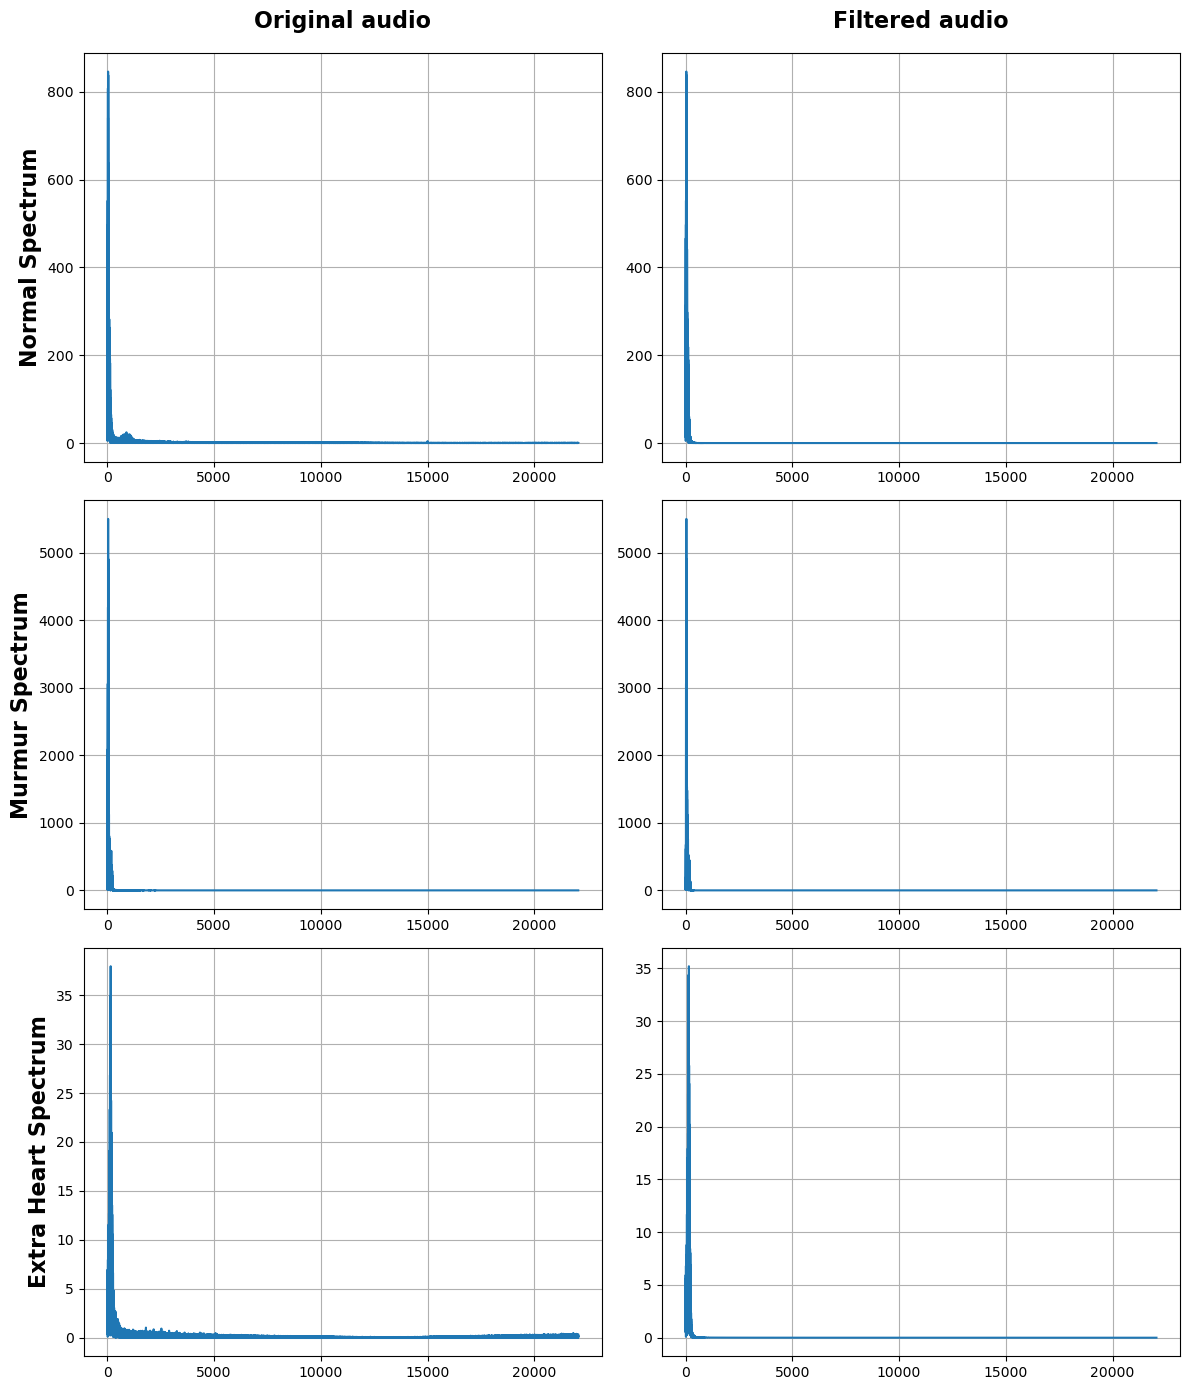

In [39]:
#@title Compare Spectrum
# Normal set A
idx = random.randint(0, len(normal_a_data)-1)
rnd_normal_a = normal_a_data[idx]
rnd_normal_a_sr = normal_a_sr[idx]
fil_normal_a = filtered_normal_a[idx]

freq_norm_or, magn_normal_or, dominant_frequency = get_spectrum(rnd_normal_a, rnd_normal_a_sr)
freq_norm_fil, magn_norm_fil, dominant_frequency = get_spectrum(fil_normal_a, rnd_normal_a_sr)

# Murmur set A
idx = random.randint(0, len(murmur_a_data)-1)
rnd_murmur_a = murmur_a_data[idx]
rnd_murmur_a_sr = murmur_a_sr[idx]
fil_murmur_a = filtered_murmur_a[idx]

freq_murmur_or, magn_murmur_or, dominant_frequency = get_spectrum(rnd_murmur_a, rnd_murmur_a_sr)
freq_murmur_fil, magn_murmur_fil, dominant_frequency = get_spectrum(fil_murmur_a, rnd_murmur_a_sr)

# Extra Heart
idx = random.randint(0, len(extrahs_data)-1)
rnd_extrahs = extrahs_data[idx]
rnd_extrahs_sr = extrahs_sr[idx]
fil_extrahs = filtered_extrahs[idx]

freq_extrahs_or, magn_extrahs_or, dominant_frequency = get_spectrum(rnd_extrahs, rnd_extrahs_sr)
freq_extrahs_fil, magn_extrahs_fil, dominant_frequency = get_spectrum(fil_extrahs, rnd_extrahs_sr)

# Extrasystole
#idx = random.randint(0, len(extrastole_data)-1)
#rnd_extrastole = extrastole_data[idx]
#rnd_extrastole_sr = extrastole_sr[idx]
#fil_extrastole = filtered_extrastole[idx]

#freq_extrastole_or, magn_extrastole_or, dominant_frequency = get_spectrum(rnd_extrastole, rnd_extrastole_sr)
#freq_extrastole_fil, magn_extrastole_fil, dominant_frequency = get_spectrum(fil_extrastole, rnd_extrastole_sr)

fig, axs = plt.subplots(3, 2, figsize=(12, 14))

axs[0, 0].plot(freq_norm_or, magn_normal_or)
axs[0,0].grid(True)
axs[0, 0].set_title('Original audio', pad=18, fontsize=16, fontweight='semibold')
axs[0, 0].set_ylabel('Normal Spectrum', fontsize=16, fontweight='bold')
axs[0, 1].plot(freq_norm_fil, magn_norm_fil)
axs[0,1].grid(True)
axs[0, 1].set_title('Filtered audio',  pad=18, fontsize=16, fontweight='bold')

axs[1, 0].plot(freq_murmur_or, magn_murmur_or)
axs[1,0].grid(True)
axs[1, 0].set_ylabel('Murmur Spectrum', fontsize=16, fontweight='bold')
axs[1, 1].plot(freq_murmur_fil, magn_murmur_fil)
axs[1,1].grid(True)

axs[2, 0].plot(freq_extrahs_or, magn_extrahs_or)
axs[2,0].grid(True)
axs[2, 0].set_ylabel('Extra Heart Spectrum', fontsize=16, fontweight='bold')
axs[2, 1].plot(freq_extrahs_fil, magn_extrahs_fil)
axs[2,1].grid(True)


#axs[3, 0].plot(freq_extrastole_or, magn_extrastole_or)
#axs[3,0].grid(True)
#axs[3, 0].set_ylabel('Extrasystole Spectrum', fontsize=16, fontweight='bold')
#axs[3, 1].plot(freq_extrastole_fil, magn_extrastole_fil)
#axs[3,1].grid(True)
    
plt.tight_layout()
plt.show()

#### Few Data


Para poder hacer un aumento de datos se pensó tomar muestras aleatorias de segmentos de audio de cada clase y hacer cambio a la velocidad de estos aumentandola o disminuyendola para que de esta forma cambie la frecuencia del latido pero no la naturaleza de la onda. Pero hay que tener en cuenta los límites normales de frecuencia de latido del corazón humano, pues se estima que un latido de corazón tiene un frecuencia aproximada de 60 a 100 latidos por minuto (1Hz - 1.66Hz) y que la frecuencia máxima que puede llegar a alcanzar es al rededor de 200 latidos por minuto (3.33Hz). Entoces teniendo en cuenta estos límites se obtiene la frecuencia del latido presente en el segmento de audio a través del análisis del espectro de frecuencias.

In [41]:
new_normal, new_normal_labels, new_normal_sr = data_aum(audio_data=filtered_normal_a, labels=normal_a_labels, sample_rates=normal_a_sr, target_num=100, min_freq=0.8, max_freq=3.5)
new_murmur, new_murmur_labels, new_murmur_sr = data_aum(audio_data=filtered_murmur_a, labels=murmur_a_labels, sample_rates=murmur_a_sr, target_num=100, min_freq=0.8, max_freq=3.5)
new_extrahs, new_extrahs_labels, new_extrahs_sr = data_aum(audio_data=filtered_extrahs, labels=extrahs_labels, sample_rates=extrahs_sr, target_num=100, min_freq=0.8, max_freq=3.5)
new_artifact, new_artifact_labels, new_artifact_sr = data_aum(audio_data=artifact_data, labels=artifact_labels, sample_rates=artifact_sr, target_num=100, min_freq=0.8, max_freq=3.5)

Text(0, 0.5, 'Num Data')

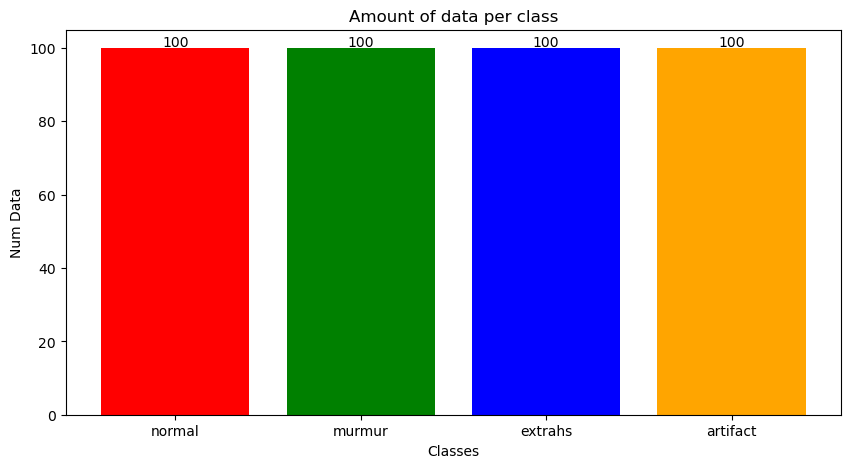

In [50]:
#@title Data distribution of each dataset
fig, axs = plt.subplots(1, 1, figsize=(10,5))
#fig.suptitle('Amount of data per class')
# Bar Graph Dataset A
plt.bar(['normal', 'murmur', 'extrahs', 'artifact'], [len(new_normal), len(new_murmur), len(new_extrahs), len(new_artifact)], color=['red', 'green', 'blue', 'orange']
)
for i, v in enumerate([len(new_normal), len(new_murmur), len(new_extrahs), len(new_artifact)]):
    plt.text(i, v + 0.5, str(v), color='black', ha='center')
# Set title subplot A
plt.title('Amount of data per class')
# Set labels subplot A
plt.xlabel('Classes')
plt.ylabel('Num Data')

### Adjust audio length

---

To adjust the duration of the audios, a time of 10 seconds was established for all, since taking into account that the common minimum frequency of a heartbeat is 60 bpm (beats per minute) or the same as 1 Hz, with this time there will be several significant samples of a complete beat in the audio segment.

For this, a sampling rate of 22050 Hz was established, which will be applied to all the audios through the **librosa** package and in this way that all the audio segments are of the same duration and the same length. Process that is implemented in the function itself: fix_audio_length()

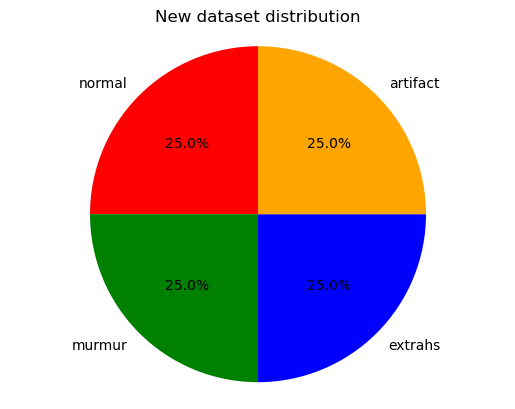

In [51]:
#@title Fix Data Length
time_duration = 10 #seconds
sr = 22050
fix_normal_data = fix_audio_length(audio_data=new_normal, orig_sr=new_normal_sr, time_duration=time_duration, target_sr=sr)
fix_murmur_data = fix_audio_length(audio_data=new_murmur, orig_sr=new_murmur_sr, time_duration=time_duration, target_sr=sr)
fix_extrahs_data = fix_audio_length(audio_data=new_extrahs, orig_sr=new_extrahs_sr, time_duration=time_duration, target_sr=sr)
fix_artifact_data = fix_audio_length(audio_data=new_artifact, orig_sr=new_artifact_sr, time_duration=time_duration, target_sr=sr)
#fix_normal_b_data = fix_audio_length(audio_data=normal_b_data, orig_sr=normal_b_sr, time_duration=time_duration, target_sr=sr)
#fix_murmur_b_data = fix_audio_length(audio_data=murmur_b_data, orig_sr=murmur_b_sr, time_duration=time_duration, target_sr=sr)
#fix_extrastole_data = fix_audio_length(audio_data=extrastole_data, orig_sr=extrastole_sr, time_duration=time_duration, target_sr=sr)

#fix_normal_data = fix_normal_a_data + fix_normal_b_data
#normal_labels = normal_a_labels + normal_b_labels
#fix_murmur_data = fix_murmur_a_data + fix_murmur_b_data
#murmur_labels = murmur_a_labels + murmur_b_labels

### Espectrogram

---

A spectrogram is a visual representation that shows how the energy of a signal varies as a function of time and frequency. It is a useful tool for analyzing audio signals, since it allows you to visualize the different frequency components present in a signal over time.

In [85]:
#@title Get spectrograms
normal_spectograms = []
murmur_spectograms = []
extrahs_spectograms = []
artifact_spectograms = []

for audio in fix_normal_data:
    normal_spectograms.append(get_spectrogram(audio=audio, sample_rate=sr))

for audio in fix_murmur_data:
    murmur_spectograms.append(get_spectrogram(audio=audio, sample_rate=sr))

for audio in fix_extrahs_data:
    extrahs_spectograms.append(get_spectrogram(audio=audio, sample_rate=sr))
    
for audio in fix_artifact_data:
    artifact_spectograms.append(get_spectrogram(audio=audio, sample_rate=sr))


In [321]:
#@title Integrate data
data = np.concatenate((normal_spectograms, murmur_spectograms, extrahs_spectograms, artifact_spectograms))
labels = np.concatenate((new_normal_labels, new_murmur_labels, new_extrahs_labels, new_artifact_labels)) 

print(f"New DataSet shape {data.shape}")
print(f"New Labels shape {labels.shape}")

New DataSet shape (400, 128, 431)
New Labels shape (400,)


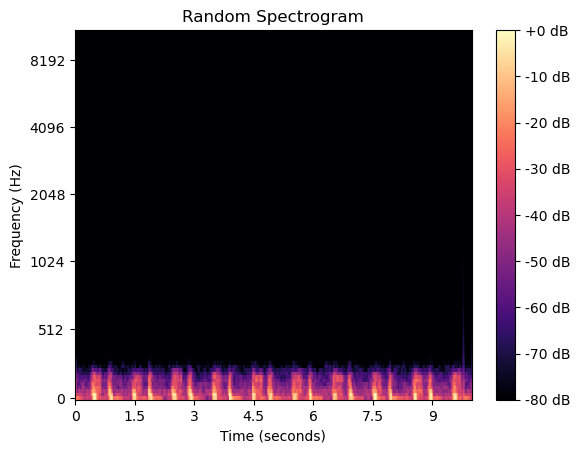

In [200]:
#@title Visualize radom spectrogram
# Display the spectrogram
idx = random.randint(0, data.shape[0]-1)

librosa.display.specshow(data[idx], sr=sr, x_axis='time', y_axis='mel')

# Add labels and title
plt.title('Random Spectrogram')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')

# Add colorbar
plt.colorbar(format='%+2.0f dB')

# Show the plot
plt.show()

In [322]:
#@title Get train and test data
np.random.seed(42)
shuffle = np.random.permutation(len(data))
data = data[shuffle]
labels = labels[shuffle]

# 70% train - 30% test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42, shuffle=True)

# Arrays with 3 dimensions (m,n,1)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Normalize de data
X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_test = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))

# One hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('Min value in X_train:',np.min(X_train),'- Max value in X_train:',np.max(X_train))
print('Min value in X_test:',np.min(X_test),'- Max value in X_test:',np.max(X_test))
print('X_train shape: ', X_train.shape, ', X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape, ', y_test shape: ', y_test.shape)

Min value in X_train: 0.0 - Max value in X_train: 1.0
Min value in X_test: 0.0 - Max value in X_test: 1.0
X_train shape:  (280, 128, 431, 1) , X_test shape:  (120, 128, 431, 1)
y_train shape:  (280, 4) , y_test shape:  (120, 4)


### Model

---

Two main metrics were used to assess model performance in classification:

- Accuracy: To be able to see the overall classification effectiveness of the model by taking the ratio between the total number of correct predictions and all the predictions.

- Recall: Which tells us how many positive predictions (the sample really is of that class) were correct (true positives, TP) among all the samples that really belong to the class (TP + FN, true positives plus false negatives).

In [416]:
#@title First Model
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(4, activation='softmax'))


In [ ]:
#@title Second Model
tf.keras.backend.clear_session()

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(rate=0.2))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(rate=0.2))

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(rate=0.1))

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))

model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [494]:
#@title Third Model
tf.keras.backend.clear_session()

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.1))


model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)))
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)))
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)))
#model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [495]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 429, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 214, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 214, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 212, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 106, 64)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 106, 64)       0

In [496]:
ln = 0.001
opt = tf.keras.optimizers.Adam(learning_rate=ln)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy', tf.keras.metrics.Recall()])

In [497]:
bs = 32
epochs = 50
early_stopping = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights = True)
history = model.fit(x=X_train, y=y_train, batch_size=bs, epochs=epochs, validation_data=(X_test, y_test), callbacks=early_stopping)

Epoch 1/50
9/9 [==============================] - 24s 2s/step - loss: 3.6948 - accuracy: 0.4179 - recall: 0.2321 - val_loss: 2.7959 - val_accuracy: 0.5000 - val_recall: 0.2833
Epoch 2/50
9/9 [==============================] - 21s 2s/step - loss: 2.5721 - accuracy: 0.5214 - recall: 0.3250 - val_loss: 2.2805 - val_accuracy: 0.6167 - val_recall: 0.3083
Epoch 3/50
9/9 [==============================] - 21s 2s/step - loss: 2.0804 - accuracy: 0.6179 - recall: 0.4179 - val_loss: 1.9363 - val_accuracy: 0.5750 - val_recall: 0.3417
Epoch 4/50
9/9 [==============================] - 21s 2s/step - loss: 1.7777 - accuracy: 0.6321 - recall: 0.4607 - val_loss: 1.7153 - val_accuracy: 0.5917 - val_recall: 0.3917
Epoch 5/50
9/9 [==============================] - 25s 3s/step - loss: 1.5881 - accuracy: 0.6357 - recall: 0.4786 - val_loss: 1.5610 - val_accuracy: 0.6333 - val_recall: 0.4583
Epoch 6/50
9/9 [==============================] - 28s 3s/step - loss: 1.4815 - accuracy: 0.6571 - recall: 0.5607 - val_l

In [485]:
eval = model.evaluate(x=X_test, y=y_test)

4/4 [==============================] - 2s 462ms/step - loss: 1.0015 - accuracy: 0.7083 - recall: 0.6250


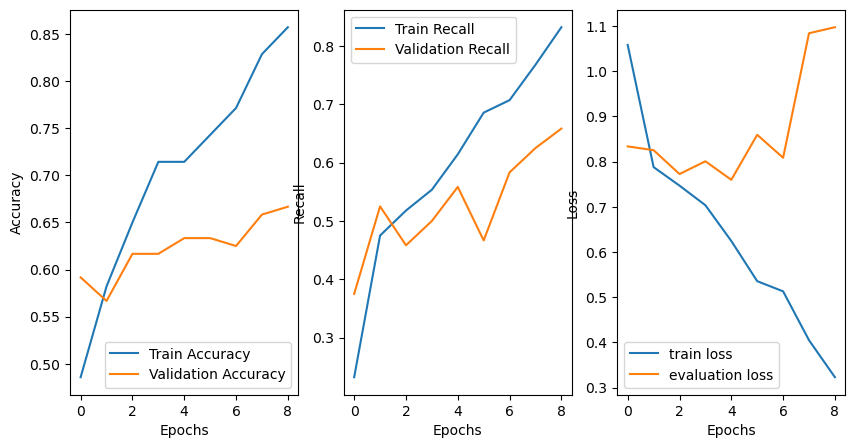

In [419]:
#@title Results Model 1
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 3, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 3, 2)
ax.plot(history.history['recall'], label='Train Recall');
ax.plot(history.history['val_recall'], label='Validation Recall');
ax.set_xlabel('Epochs');
ax.set_ylabel('Recall');
ax.legend();
ax = fig.add_subplot(1, 3, 3)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

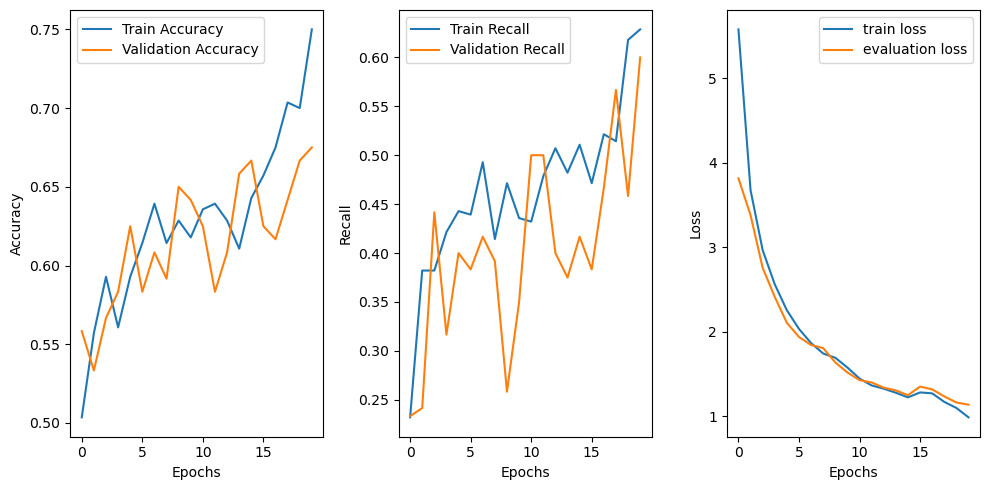

In [424]:
#@title Results Model 2
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 3, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 3, 2)
ax.plot(history.history['recall'], label='Train Recall');
ax.plot(history.history['val_recall'], label='Validation Recall');
ax.set_xlabel('Epochs');
ax.set_ylabel('Recall');
ax.legend();
ax = fig.add_subplot(1, 3, 3)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');
plt.tight_layout()

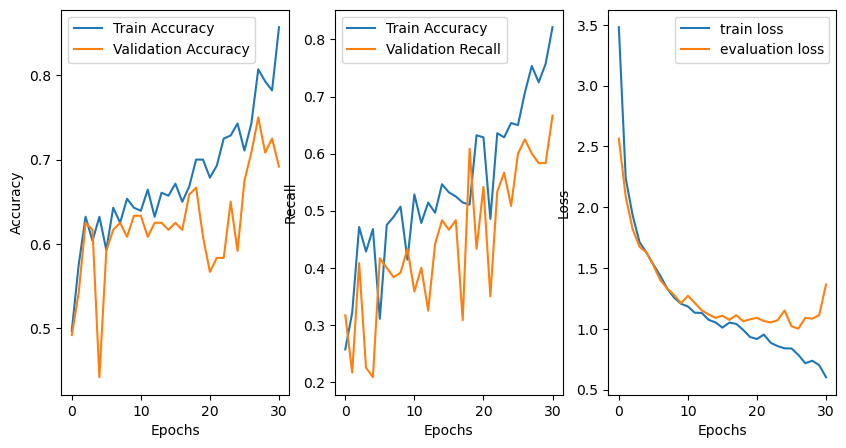

In [486]:
#@title Better configuration model
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 3, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 3, 2)
ax.plot(history.history['recall'], label='Train Accuracy');
ax.plot(history.history['val_recall'], label='Validation Recall');
ax.set_xlabel('Epochs');
ax.set_ylabel('Recall');
ax.legend();
ax = fig.add_subplot(1, 3, 3)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');
ax.legend();